In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, classification_report, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df = pd.read_csv('NPHA-doctor-visits.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 15 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Number of Doctors Visited                   714 non-null    int64
 1   Age                                         714 non-null    int64
 2   Phyiscal Health                             714 non-null    int64
 3   Mental Health                               714 non-null    int64
 4   Dental Health                               714 non-null    int64
 5   Employment                                  714 non-null    int64
 6   Stress Keeps Patient from Sleeping          714 non-null    int64
 7   Medication Keeps Patient from Sleeping      714 non-null    int64
 8   Pain Keeps Patient from Sleeping            714 non-null    int64
 9   Bathroom Needs Keeps Patient from Sleeping  714 non-null    int64
 10  Uknown Keeps Patient from Sleeping    

In [3]:
df.describe()

,Number of Doctors Visited,Age,Phyiscal Health,Mental Health,Dental Health,Employment,Stress Keeps Patient from Sleeping,Medication Keeps Patient from Sleeping,Pain Keeps Patient from Sleeping,Bathroom Needs Keeps Patient from Sleeping,Uknown Keeps Patient from Sleeping,Trouble Sleeping,Prescription Sleep Medication,Race,Gender
count,714.000000,714.0,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.00000
mean,2.112045,2.0,2.794118,1.988796,3.009804,2.806723,0.247899,0.056022,0.218487,0.504202,0.417367,2.407563,2.829132,1.425770,1.55042
std,0.683441,0.0,0.900939,0.939928,1.361117,0.586582,0.432096,0.230126,0.413510,0.500333,0.493470,0.670349,0.546767,1.003896,0.49780
min,1.000000,2.0,-1.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,1.000000,1.00000
25%,2.000000,2.0,2.000000,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,1.000000,1.00000
50%,2.000000,2.0,3.000000,2.000000,3.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,3.000000,1.000000,2.00000
75%,3.000000,2.0,3.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000,3.000000,1.000000,2.00000
max,3.000000,2.0,5.000000,5.000000,6.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,5.000000,2.00000


In [4]:
print(df.head(3))

   Number of Doctors Visited  Age  Phyiscal Health  Mental Health  \
0                          3    2                4              3   
1                          2    2                4              2   
2                          3    2                3              2   

   Dental Health  Employment  Stress Keeps Patient from Sleeping  \
0              3           3                                   0   
1              3           3                                   1   
2              3           3                                   0   

   Medication Keeps Patient from Sleeping  Pain Keeps Patient from Sleeping  \
0                                       0                                 0   
1                                       0                                 0   
2                                       0                                 0   

   Bathroom Needs Keeps Patient from Sleeping  \
0                                           0   
1                                  

# Data Cleaning
Handling -1(Refused), -2(Not asked) values in the features.

In [6]:
# Check missing values.
df.isnull().sum()

# Filter out the rows with values -1 or -2 in the features.
for _, col in enumerate(df.columns):
    count = df[col].isin([-1, -2]).sum()
    print(col, count)
    df = df[~df[col].isin([-1, -2])]

Number of Doctors Visited 0
Age 0
Phyiscal Health 1
Mental Health 10
Dental Health 3
Employment 0
Stress Keeps Patient from Sleeping 0
Medication Keeps Patient from Sleeping 0
Pain Keeps Patient from Sleeping 0
Bathroom Needs Keeps Patient from Sleeping 0
Uknown Keeps Patient from Sleeping 0
Trouble Sleeping 2
Prescription Sleep Medication 2
Race 0
Gender 0


# Analyze Class Distribution
We found bias towards Class 2. It will need to rebalance the data using techniques like SMOTE, random oversampling for underrepresented classes, or undersampling for the overrepresented class.

In [8]:
# Calculate the class distribution
class_distribution = df['Number of Doctors Visited'].value_counts()
print(class_distribution)

Number of Doctors Visited
2    363
3    207
1    126
Name: count, dtype: int64


# Data Exploration and Visulization
The distribution of age, race, gender
* It shows that 100% of the entries fall into the "65-80" age category as per the patient's age group, this indicates a strong bias or imbalance in the dataset regarding age distribution.

* Based on the distribution percentages for the patient's racial or ethnic background, it appears that the dataset is imbalanced with a significant overrepresentation of the "White, Non-Hispanic" category compared to other categories.

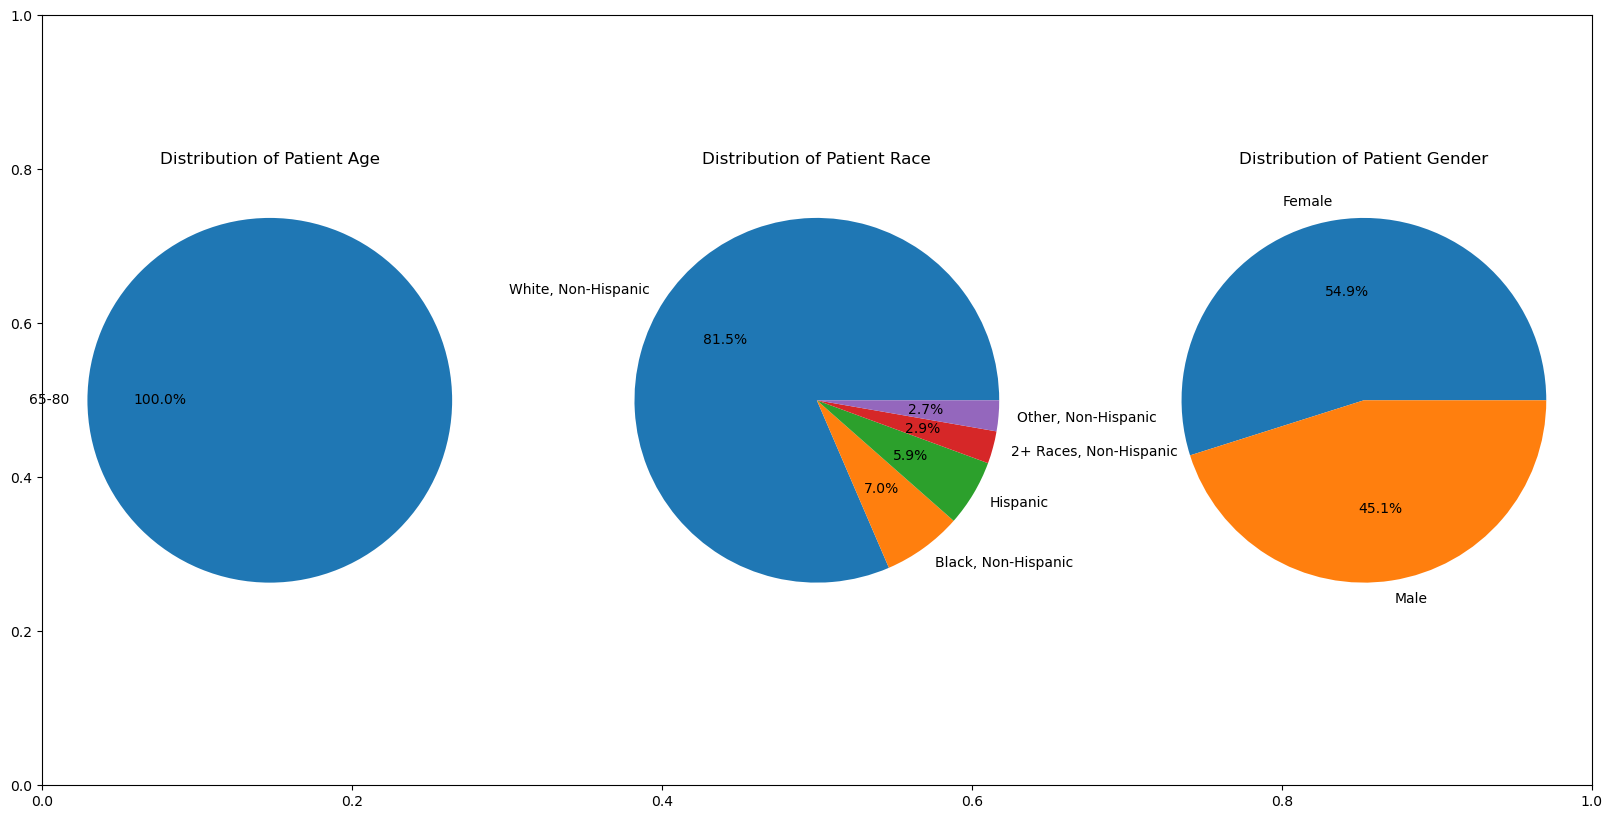

In [10]:
df_ = df.copy()

age_dict = { 1: "50-64", 2: "65-80" }
df_['Age'] = df_['Age'].map(age_dict)

race_dict = { 1: "White, Non-Hispanic", 2: "Black, Non-Hispanic", 3: "Other, Non-Hispanic", 4: "Hispanic", 5: "2+ Races, Non-Hispanic" }
df_['Race'] = df_['Race'].map(race_dict)

gender_dict = { 1: "Male", 2: "Female" }
df_['Gender'] = df_['Gender'].map(gender_dict)

plt.subplots(figsize=(20, 10))
for i, col in enumerate(['Age', 'Race' , 'Gender']):
    plt.subplot(1, 3, i + 1)
 
    x = df_[col].value_counts()
    plt.title('Distribution of Patient ' + col)
    plt.pie(x.values,
            labels=x.index,
            autopct='%1.1f%%')
 
plt.show()

2. The distribution of physical, mental, dental health and other lifestyle factors

# Correlation Analysis
`Physical Health` have strong correlation with `Number of Doctors Visited` and strong interrelation with `MentalHealth`, indicating it is a significant predictor of healthcare utilization and overall health status.

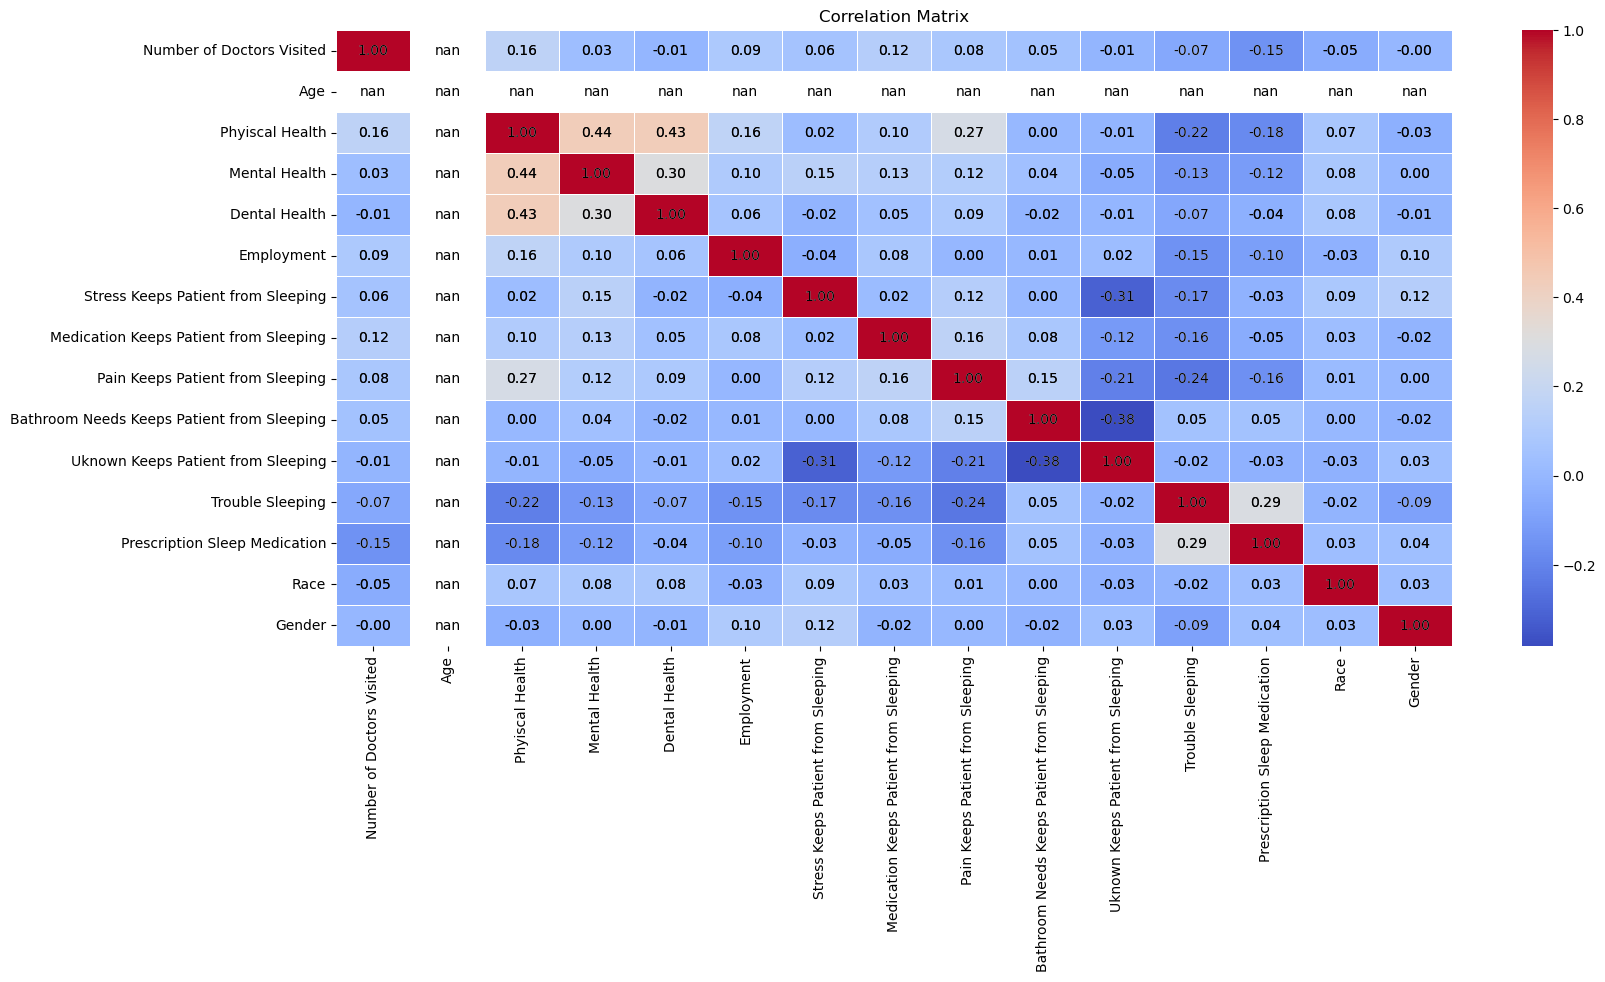

In [13]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)

# Add annotations to the heatmap
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        text = f"{corr_matrix.iloc[i, j]:.2f}"
        plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

plt.title("Correlation Matrix")
plt.show()

# Analysing Feature Importances

<Figure size 1000x600 with 0 Axes>

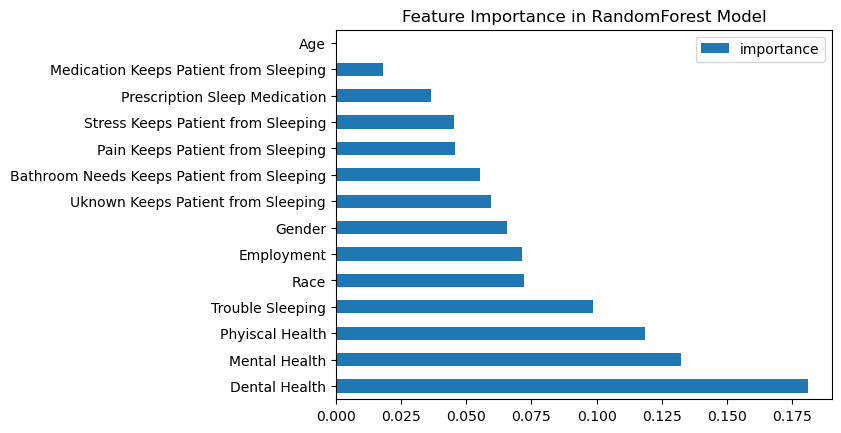

In [15]:
X = df.drop('Number of Doctors Visited', axis=1)
y = df['Number of Doctors Visited']

model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X, y)

# # Extract Feature Importances
feature_importances = pd.DataFrame(model.feature_importances_, 
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='barh')  
plt.title('Feature Importance in RandomForest Model')
plt.show()

# Feature Selection
In an effort to reduce dimensionality, one of approches We tried to combine various sleep-related disturbances into a single metric based on the Feature Importances and the Correlation Matrix but We didn't see a significant impact on model performance. Domain experts could potentially provide insights into known clinical/causal links between certain variables.

In [17]:
# We will drop the Age feature as it has 0 importances.
columns_to_drop = ['Age']
X = X.drop(columns=columns_to_drop)

# Model Development
**1. Spliting into Train and Test**

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**2. SMOTE for Balancing Data**

The Synthetic Minority Oversampling Technique to generate synthetic samples for the minority class based on nearest neighbors.

 We tested Random Forest, SVC models without resampling, the models were performing well on the majority class which is Class 2 but poorly on the minority class - Precision, recall, and F1-score were all 0 on Class 1.

In [21]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", Counter(y_train_resampled))

Class distribution after SMOTE: Counter({2: 289, 3: 289, 1: 289})


**3. Feature Scaling**

In [23]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

**4. Machine Learning Modeling**

Prediction and Evaluation: The model’s performance is evaluated using accuracy and a detailed classification report, which includes precision, recall, and F1-score for each class.

* Precision: Indicates the accuracy of positive predictions.
* Recall: Indicates the ability to find all positive instances.
* F1-Score: Harmonic mean of precision and recall.

In [25]:
# Evaluate the performance of the model

def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Print evaluation results
    print("Confusion Matrix:\n", matrix)
    print("Classification Report:\n", class_report)

In [26]:
X_scaled = np.vstack((X_train_scaled, X_test_scaled))
y = np.concatenate((y_train_resampled, y_test))

# Initializing Models
models = {
    "LogisticRegression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(kernel ='linear'),
    "DecisionTree": DecisionTreeClassifier()
}

cv = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

# Producing cross validation score for the models
for model_name in models:
    model = models[model_name]
    
    # Evaluate the model's accuracy using cross-validation
    accuracies = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
    
    print("🚀", model_name)
    print("Average accuracy:", np.mean(accuracies))

    model.fit(X_train_scaled, y_train_resampled)
    evaluate(model, X_test_scaled, y_test)

🚀 LogisticRegression
Average accuracy: 0.47162376237623765
Confusion Matrix:
 [[ 7 11  5]
 [22 26 26]
 [14 16 13]]
Classification Report:
               precision    recall  f1-score   support

           1       0.16      0.30      0.21        23
           2       0.49      0.35      0.41        74
           3       0.30      0.30      0.30        43

    accuracy                           0.33       140
   macro avg       0.32      0.32      0.31       140
weighted avg       0.38      0.33      0.34       140

🚀 Random Forest
Average accuracy: 0.6007524752475247
Confusion Matrix:
 [[ 3 16  4]
 [10 44 20]
 [14 16 13]]
Classification Report:
               precision    recall  f1-score   support

           1       0.11      0.13      0.12        23
           2       0.58      0.59      0.59        74
           3       0.35      0.30      0.33        43

    accuracy                           0.43       140
   macro avg       0.35      0.34      0.34       140
weighted avg       0.

**5. Cross-validation Results**
Based on the results above, the Random Forest model performs better compared to the other models.

* Average Accuracy: 60.4% (reported as higher, but confusion matrix suggests lower effective accuracy)
* Reported Accuracy: 41% as the effective accuracy, which reflects the proportion of total correct predictions across all classes.

# Hyperparameter Optimization
**1. BayesSearchCV with RandomForestClassifier**

We will use BayesSearchCV to perform hyperparameter optimization for the Random Forest algorithm. BayesSearchCV from the scikit-optimize library is a powerful tool for hyperparameter tuning that uses Bayesian optimization techniques.

When tuning hyperparameters for RandomFoestClassifier, there was a significant difference between the training score and the test score. But as the value of the `min_samples_split`, `min_samples_leaf` parameters increases, the difference between the train score and the test score decreased.

In [29]:
y_train = y_train_resampled.values.ravel()
# Define the parameter search space
search_spaces = {
    'bootstrap': [False],
    'n_estimators': (10, 300),
    'max_depth': (1, 15),
    'min_samples_split': (3, 20),
    'min_samples_leaf': (2, 10)
}
# Create a BayesSearchCV instance
bayes_cv = BayesSearchCV(
    estimator=RandomForestClassifier(),
    search_spaces=search_spaces,
    n_iter=100,  
    cv=5,  
    n_jobs=-1,  
    scoring='accuracy'  
)


# Fit the optimizer to data
bayes_cv.fit(X_train_scaled, y_train)

# Evaluate the performance of the best estimator
print("Train score: %s" % bayes_cv.best_score_)
print("Best params: %s" % str(bayes_cv.best_params_))

rf = bayes_cv.best_estimator_
evaluate(rf, X_test_scaled, y_test)

Train score: 0.6450335525878679
Best params: OrderedDict({'bootstrap': False, 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 300})
Confusion Matrix:
 [[ 4 15  4]
 [12 38 24]
 [14 16 13]]
Classification Report:
               precision    recall  f1-score   support

           1       0.13      0.17      0.15        23
           2       0.55      0.51      0.53        74
           3       0.32      0.30      0.31        43

    accuracy                           0.39       140
   macro avg       0.33      0.33      0.33       140
weighted avg       0.41      0.39      0.40       140



**2. BayesSearchCV with SVC**

Particularly with the inclusion of the polynomial kernel (poly), computational time increases significantly.

In [31]:
# Define the parameter search space
search_space = {
    'C': Real(1e-6, 1e+6, prior='log-uniform'),
    'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'kernel': Categorical(['rbf'])
}

# Create a BayesSearchCV instance
bayes_cv = BayesSearchCV(
    estimator=SVC(),
    search_spaces=search_space,
    scoring = 'accuracy',
    cv = 5,
    n_iter = 100,
    n_jobs = -1,
    random_state = 42 
)

# Fit the optimizer to data
bayes_cv.fit(X_train_scaled, y_train)
# Evaluate the performance of the best estimator
print("Train score: %s" % bayes_cv.best_score_)
print("Best params: %s" % str(bayes_cv.best_params_))

evaluate(bayes_cv.best_estimator_, X_test_scaled, y_test)

Train score: 0.6149491728124378
Best params: OrderedDict({'C': 1000000.0, 'gamma': 10.0, 'kernel': 'rbf'})
Confusion Matrix:
 [[ 3 17  3]
 [ 7 58  9]
 [ 9 29  5]]
Classification Report:
               precision    recall  f1-score   support

           1       0.16      0.13      0.14        23
           2       0.56      0.78      0.65        74
           3       0.29      0.12      0.17        43

    accuracy                           0.47       140
   macro avg       0.34      0.34      0.32       140
weighted avg       0.41      0.47      0.42       140



**3. BayesSearchCV with DecisionTreeClassifier**

In [56]:
# Define the parameter search space
search_spaces = {
    'criterion': ['gini', 'entropy'],
    'max_depth': (1, 15),
    'min_samples_split': (3, 4),
    'min_samples_leaf': (2, 3),
}

# Create a BayesSearchCV instance
bayes_cv = BayesSearchCV(
    estimator=DecisionTreeClassifier(),
    search_spaces=search_spaces,
    n_iter=100,  
    cv=5, 
    n_jobs=-1,  
    scoring='accuracy'  
)

# Fit the optimizer to data
bayes_cv.fit(X_train_scaled, y_train)

# Evaluate the performance of the best estimator
print("Train score: %s" % bayes_cv.best_score_)
print("Best params: %s" % str(bayes_cv.best_params_))

evaluate(bayes_cv.best_estimator_, X_test_scaled, y_test)

Train score: 0.573430336854694
Best params: OrderedDict({'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 3})
Confusion Matrix:
 [[ 3 12  8]
 [21 30 23]
 [12 19 12]]
Classification Report:
               precision    recall  f1-score   support

           1       0.08      0.13      0.10        23
           2       0.49      0.41      0.44        74
           3       0.28      0.28      0.28        43

    accuracy                           0.32       140
   macro avg       0.28      0.27      0.28       140
weighted avg       0.36      0.32      0.34       140



# Model Selection


Based on the results for RandomForest, SVC (Support Vector Classifier), and Decision Tree models, RandomForest has the highest training score. In terms of test accuracy, SVC slightly outperforms the other models.

In the precision, recall, and f1 scores, RandomForest generally shows balanced performance across classes but struggles with Class 1. SVC shows better performance for Class 2, which is the majority class, it might be better at identifying more common scenarios. Decision Tree shows a diverse but not significantly better performance pattern.

SVC might offer better performance for the specific task but RandomForest would be a strong choice on the grounds of interpretability, computational efficiency, and more balanced class performance. These factors are crucial in healthcare applications.

# Model Insights

Our RandomForest model has identified several key predictors that influence the frequency of doctor visits among the elderly. The features deemed most critical, based on their importance scores, are outlined below in their order of impact.

<Figure size 1000x600 with 0 Axes>

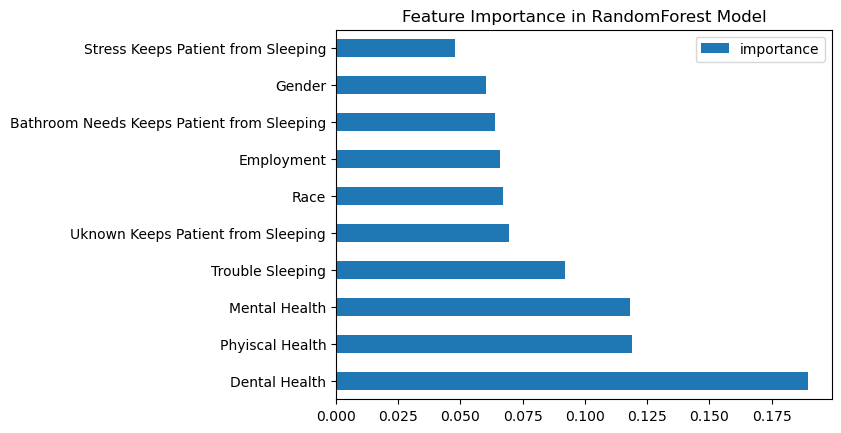

In [36]:
feature_importances = pd.DataFrame(rf.feature_importances_, 
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
feature_importances.head(10).plot(kind='barh')  # Top 10 features
plt.title('Feature Importance in RandomForest Model')
plt.show()

# Conclusion 

The model currently shows signs of overfitting with significant discrepancies between training and test performance. It should not be used for critical healthcare decisions. It's essential to improve the model's precision and recall across all classes to make it a reliable tool.

Collecting more data and enhancing feature engineering are crucial steps in improving model performance. More data provides the model with a diverse set of examples, reducing overfitting and improving generalization. Enhanced feature engineering helps in creating better features and incorporating relevant data, leading to improved accuracy and capturing hidden patterns in the data.